In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import time
%matplotlib inline

import H_mat

# Модуль H_mat

Модуль H_mat (код в файле H_mat.py) содержит класс H_matrix для работы с Н-матрицами (блочно-скелетонным разложением матриц). В формате H_matrix реализованы сложение и умножение матриц, построение обратной матрицы и LU разложение.

Н-матрицы имеют иерархическую структуру. Матрица М разбита на четыре блока $M_{11}$, $M_{12}$, $M_{21}$, $M_{22}$ следующим образом: 

$$
|M_{11} M_{12}|
$$
$$
|M_{21} M_{22}|    
$$

Блоки $M_{ij}$, имеющие ранг r, меньший заданного r_max, хранятся в виде факторов $a \in R^{n \times r}$ и $b \in R^{r \times m}$, $M_{ij} = a b$. Блоки, не имеющие достаточно малого ранга, разбиваются на подблоки в иерархической манере, и малоранговость проверяется для подблоков. Блоки размера, меньшего 2 * r_max, хранятся в виде плотной матрицы.

## Тестовая задача

Для того, чтобы продемонстрировать работу модуля, рассмотрим тестовую одномерную задачу с логарифмическим ядром. На отрезке [0,1] равномерно расположено N зарядов с координатами $x_i$, воздействующими друг на друга с силой, пропорциональной логарифму растояния. Суммарные силы, действующие на заряды, $b_i$ известны. Необходимо найти массы зарядов $m_i$, на которые можно составить следующее уравнение:


$$
b_i = \Sigma_{j=1}^N m_i log(|x_i - x_j|)
$$

Матрица $M_{i,j} = log(|x_i - x_j|)$ имеет блочно-малоранговую структуру. Ее генерирует функция gen_matrix(n), описанная ниже. 

In [2]:
def kernel(x, y):
    return np.log(np.abs(x - y))

In [3]:
def gen_matrix(n):
    xs = np.linspace(0,1,n)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                M[i, j] = kernel(xs[i], xs[j]) 
            else:
                M[i, j] = 0
    return M

Сгенерируем и визуализируем матрицу M для N = 500. 

In [4]:
M = gen_matrix(500)  

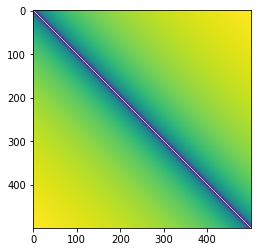

In [5]:
plt.imshow(M)

Наибольшие по модулю элементы сосредоточены вблизи диагонали, но на диагонали - нули. Эта матрица имеет Н-структуру. 

Функция H_mat.create(M, tol, rang) строит Н-матрицу по плотной матрице M. Проверка на малоранговость и разложение на факторы выполняются при помощи SVD. Зная ядро и сетку можно построить H-матрицу без построения плотной матрицы M, но в данном коде такая возможность не риализована. 

Параметры: ранг блока считается малым, если блок имеет не более 'rang' сингулярных чисел, превышающих 'tol'.

In [6]:
H = H_mat.create(M, 1e-6, 10)

Функция H.show() позволяет визуализировать блочную структуру матрицы H

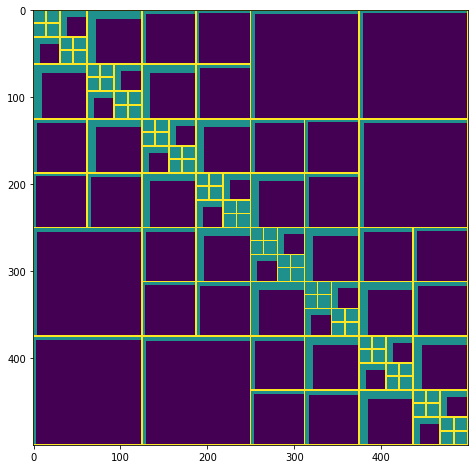

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(H.show())

Желтым обозначены границы блоков. Полностью зеленые блоки имеют плотную структуру. Другие блоки имеют малый ранг, причем ширина зеленой линии соответствует рангу матрицы. Плотные блоки сосредоточены на диагонали. Чем дальше от диагонали, тем ранг блогов ниже, что соответствует тому, что удаленные от диагонали блоки описывают взаимодействие далеко разнесенных групп точек.

## Сложение

Для того, чтобы показать, что сложение работает, сложем матрицу Н с самой собой.

In [8]:
H_sum = H + H

функция H_sum.mat() возвращает плотную матрицу. H_sum.mat() должны быть равна H.mat() + H.mat(). Для того, чтобы проверить это равенство, используем функцию np.linalg.norm, вычисляющую вторую норму. Относительная погрешность при сложении H-матриц имеет порядок 1e-16.

In [9]:
np.linalg.norm(H_sum.mat() - H.mat() - H.mat()) / np.linalg.norm(H_sum.mat())

2.771195375023886e-16

Матрица Н_sum имеет такую же блочную структуру, как и матрица Н, что видно на следующем графике

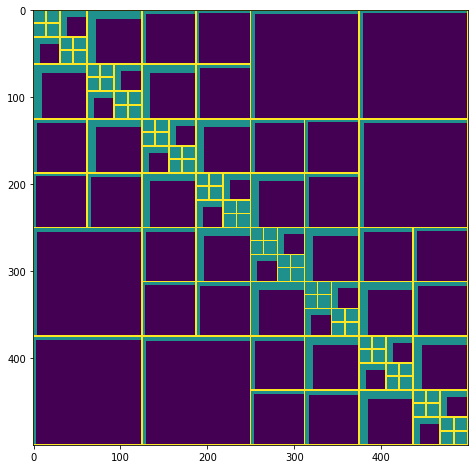

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(H_sum.show())

## Умножение

Для того, чтобы показать, что умножение работает, посчитаем матрицу H_mul = H * H

In [11]:
H_mul = H @ H

Относительная ошибка умножения, вычисленая ниже, и имеет порядок 1e-15

In [12]:
np.linalg.norm(H_mul.mat() - H.mat() @ H.mat()) / np.linalg.norm(H_mul.mat())

4.18459658695082e-15

Блочная структура матрицы H_mul приведена ниже. Она имеет такую же блочную структуру, как и матрица Н.

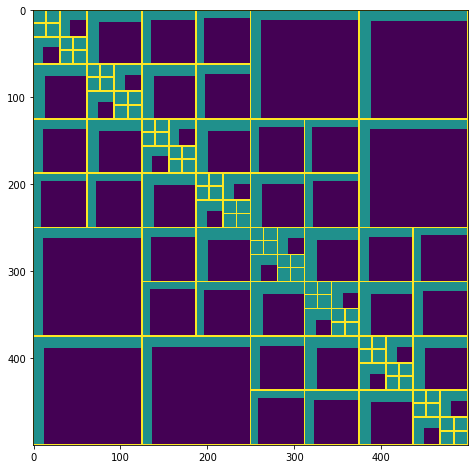

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(H_mul.show())

## Обращение матриц

Вычислим матрицу H_inv, обратную к матрице H

In [14]:
H_inv = H.inv()

Относительная погрешность вычисления обратной матрицы имеет порядок 1e-10. Для обращения плотной матрицы использована функция np.linalg.inv()

In [15]:
np.linalg.norm(np.linalg.inv(H.mat()) - H_inv.mat()) / np.linalg.norm(H.mat())

2.9021630494523856e-10

Обратная матрица имеет ту же блочную структуру, что и матрица H.

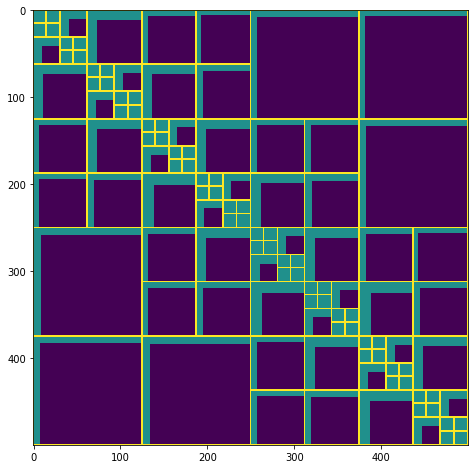

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(H_inv.show())

Зная обратную матрицу решим систему Hx = b. Случайный вектор b сгенерируем функцией np.rand.random(N)

In [17]:
b = np.random.rand(500)

Решим систему

In [18]:
x = H_inv @ b

Равенство Hx = b выполняется с относительной погрешностью 1e-8

In [19]:
np.linalg.norm(H.mat() @ x - b) / np.linalg.norm(b)

2.16155775140989e-08

## LU факторизация

Проверим работоспособность LU факторизации, которую строит функция H.lu()

In [23]:
L, U = H.lu()

Ниже изображена блочная структура факторов L и U. Это нижняя и верхняя треугольные матрицы, имеющие такую же блочную структуру, как матрица H.

Text(0.5, 1.0, 'U factor')

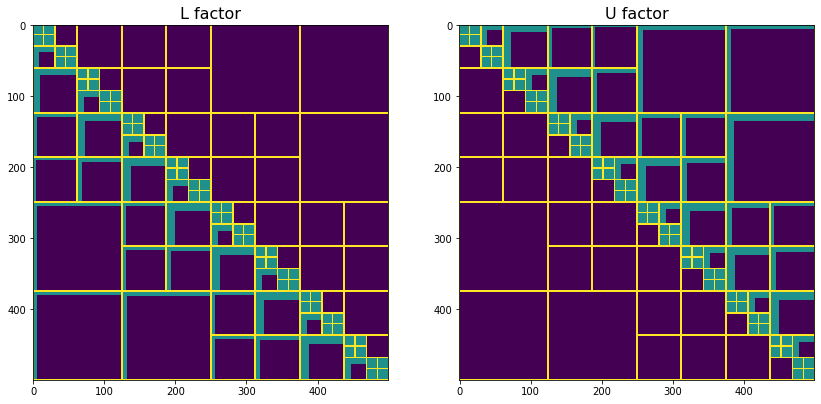

In [24]:
plt.figure(figsize=(14,14))
plt.subplot(1,2,1)
plt.imshow(L.show())
plt.title('L factor', fontsize=16)

plt.subplot(1,2,2)
plt.imshow(U.show())
plt.title('U factor', fontsize=16)

Равенство LU = H выполняется с относительной точностью 1e-9.

In [25]:
np.abs(L.mat() @ U.mat() - H.mat()).max()

5.398435920511702e-09

Зная L и U, найдем решение системы Hx = b, используя функцию H_mat.lu_solve(L, U, b)

In [26]:
x = H_mat.lu_solve(L, U, b)

Вектор x удовлетворяет уравнению Hx = b с относительной погрешностью 1e-8

In [27]:
np.linalg.norm(H.mat() @ x - b)

8.583530635037756e-09

## Асимптотическая сложность реализованных методов

Для того, чтобы оценить сложность реализованных методов, построим серию матриц со значением n = [100, 200, 400, 800, 1600, 3200]. Матрицы сохраняем в списке h_mat.

In [208]:
ns = [100, 200, 400, 800, 1600, 3200]
h_mat = []

for n in ns:
    h1 = H_mat.create(gen_matrix(n), 1e-6, 10)
    h_mat.append(h1)

## Память

Оценим необходимую для хранения Н-матрицы память. Функция H.mem() возвращает число переменных типа double, хранящихся на нижних уровнях матрицы.

In [254]:
memory = []
for h1 in h_mat:
    memory.append(h1.mem())

Из приведенного ниже графика можно видеть, что объем памяти (синяя жирная линия), необходимая для хранения Н-матрицы, растет с ростом n чуть быстрее, чем линейно (линеяная зависимсоть - черная сплощная линии)

Text(0.5, 0, 'n')

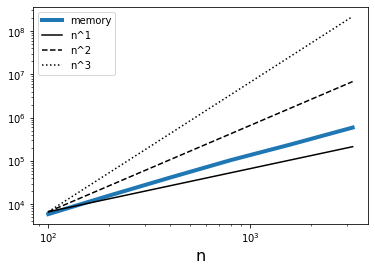

In [256]:
plt.loglog(ns, memory, label="memory", lw=4)
plt.plot(ns, [n/1.5e-2 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/1.5e0 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/1.5e2 for n in ns], 'k:',label="n^3")
#plt.plot(ns, [n**3 for n in ns], label="n^3")
plt.legend()
plt.xlabel("n", fontsize=16)

## Сложность сложения

In [257]:
sum_time = []
for h1 in h_mat:    
    m = 5
    time1 = time.process_time()
    for i in range(m):
        h0 = h1 + h1
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    sum_time.append(dtime)

На графике ниже приведено время, необходимое для выполнения сложения (жирная синяя линия). Оно растёт с ростом n линейно. Вероятно, чуть быстрее, чем линейно, так как необходимая для хранения матриц память растет чуть быстрее, чем линейно, как показано выше.

Text(0.5, 0, 'n')

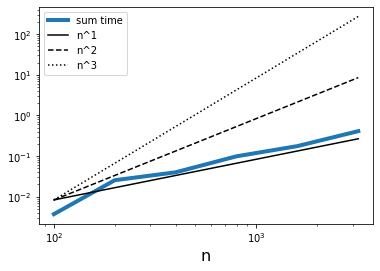

In [65]:
plt.loglog(ns, sum_time, label="sum time", lw=4)
plt.plot(ns, [n/1.2e4 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/1.2e6 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/1.2e8 for n in ns], 'k:',label="n^3")
#plt.plot(ns, [n**3 for n in ns], label="n^3")
plt.legend()
plt.xlabel("n", fontsize=16)

## Сложность умножение

In [67]:
mul_time = []
for h1 in h_mat:
    m = 1
    time1 = time.process_time()
    for i in range(m):
        h0 = h1 @ h1
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    mul_time.append(dtime)

Время умножения матриц связано с n квадратично (n^2 -- прерывистая линия)

Text(0.5, 0, 'n')

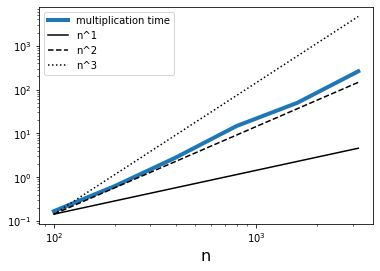

In [71]:
plt.loglog(ns, mul_time, label="multiplication time", lw=4)
plt.plot(ns, [n/0.7e3 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/0.7e5 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/0.7e7 for n in ns], 'k:',label="n^3")
#plt.plot(ns, [n**3 for n in ns], label="n^3")
plt.legend()
plt.xlabel("n", fontsize=16)

## Сложность обращения

In [69]:
inv_time = []
for n, h1 in zip(ns, h_mat):
    m = 1
    time1 = time.process_time()
    for i in range(m):
        h0 = h1.inv()
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    inv_time.append(dtime)

Время обращения матриц также квадратично.

Text(0.5, 0, 'n')

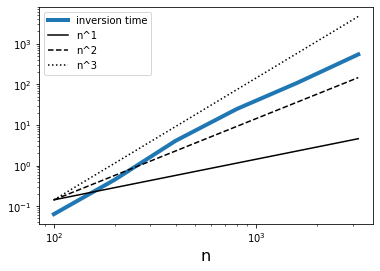

In [70]:
plt.loglog(ns, inv_time, label="inversion time", lw=4)
plt.plot(ns, [n/0.7e3 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/0.7e5 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/0.7e7 for n in ns], 'k:',label="n^3")
#plt.plot(ns, [n**3 for n in ns], label="n^3")
plt.legend()
plt.xlabel("n", fontsize=16)

## LU факторизация

In [218]:
luf_time = []
lus_time = []
for n, h1 in zip(ns, h_mat):
    
    time1 = time.process_time()
    L, U = h1.lu()
    time2 = time.process_time()
    
    dtime = (time2 - time1)
    luf_time.append(dtime)
    
    b = np.random.rand(n)
    time1 = time.process_time()
    x = H_mat.lu_solve(L, U, b)
    time2 = time.process_time()
    
    dtime = (time2 - time1)
    lus_time.append(dtime)

На графике ниже синяя жирная линия показывается время, затраченное на факторизацию, жирная оранжевая линии -- время на решение факторизованной системы. Обе задачи имеют квадратичную сложность.

Text(0.5, 0, 'n')

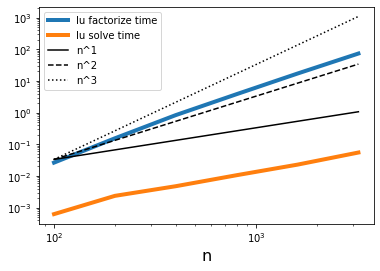

In [258]:
plt.loglog(ns, luf_time, label="lu factorize time", lw=4)
plt.loglog(ns, lus_time, label="lu solve time", lw=4)
plt.plot(ns, [n/3e3 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/3e5 for n in ns], 'k--',label="n^2")
plt.plot(ns, [n**3/3e7 for n in ns], 'k:',label="n^3")
#plt.plot(ns, [n**3 for n in ns], label="n^3")
plt.legend()
plt.xlabel("n", fontsize=16)

## Заключение

На Python + numpy реализован наивный алгоритм для работы с Н-матрицами. Показано, что в Н-формате алгебраические операции, обращение и LU-факторизация матриц работает корректно. Показано, что сложение требует примерно O(n) времени; умножение, обращение и факторизация - O(n^2).

Как можно ускорить этот код? 

- Найти и реализовать более совершенные алгоритмы для работы с Н-матрицами. 
- Найти и исключить лишние копирования. 
- Применить библиотеку, в которой основные операции для работы с многомерными массивами могут выполняться параллельно или на GPU. Сейчас мне кажется, что это может быть Pytorch или TensorFlow.

Можно переписать код на C++. Не уверен, что это позволит сильно ускорить код, так как основное время вычисления занимают операции с плотными матрицами, для выполнения которых numpy обращается к Lapack.